# Bar Graph Classification

Teng-Jui Lin

- Created: 2023-05-27
- Edited: 2024-07-15

In [1]:
from bar_constants import *
set_save_fig_rc()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Calculate article statistics

### Import Zotero article data

In [2]:
# import zotero article data
articles_df = pd.DataFrame()
for i, journal in enumerate(JOURNALS):
    filepath = f'data/zotero_data'
    filename = os.path.join(filepath, f'{journal}.csv')
    articles_df_ = pd.read_csv(filename)
    articles_df = pd.concat([articles_df, articles_df_])
articles_df.shape

(3387, 87)

### Calculate number of authors

In [3]:
# extract individual authors
authors_df_ = articles_df['Author'].str.split(';', expand=True)
# calculate number of authors
num_authors_series = (~pd.isna(authors_df_)).sum(axis=1)
articles_df[NUM_AUTHORS_LABEL] = num_authors_series

In [4]:
# extract individual word in title
NUM_WORDS_TITLE_LABEL = 'Title Word Count'
title_df_ = articles_df['Title'].str.split(' ', expand=True)
# calculate number of words in title
title_series = (~pd.isna(title_df_)).sum(axis=1)
articles_df[NUM_WORDS_TITLE_LABEL] = title_series

### Add article statistics labels

In [5]:
def assign_boolean(df, regex, label, assigned_bool):
    df.loc[df[MANUAL_TAGS_LABEL].str.contains(regex), label] = assigned_bool

In [6]:
# mutually exclusive label: does the article has at least 1 bar graph
articles_df[HAS_BAR_GRAPH_LABEL] = True
assign_boolean(articles_df, NO_BAR_GRAPH_REGEX_LABEL, HAS_BAR_GRAPH_LABEL, False)

In [7]:
# mutually exclusive label: does the article has at least 1 inaccurate bar graph
# separated into two columns because have articles with no bar graph
articles_df[NO_MISUSE_LABEL] = False
articles_df[HAS_MISUSE_LABEL] = False
assign_boolean(articles_df, NO_MISUSE_REGEX_LABEL, NO_MISUSE_LABEL, True)
assign_boolean(articles_df, HAS_MISUSE_REGEX_LABEL, HAS_MISUSE_LABEL, True)

In [8]:
# non-mutually exclusive labels with one hot encoding
# log, zero, others
articles_df[ZERO_PROBLEM_LABEL] = False
articles_df[LOG_PROBLEM_LABEL] = False
articles_df[OTHER_PROBLEM_LABEL] = False
assign_boolean(articles_df, ZERO_PROBLEM_REGEX_LABEL, ZERO_PROBLEM_LABEL, True)
assign_boolean(articles_df, LOG_PROBLEM_REGEX_LABEL, LOG_PROBLEM_LABEL, True)
assign_boolean(articles_df, OTHER_PROBLEM_REGEX_LABEL, OTHER_PROBLEM_LABEL, True)

In [9]:
def get_article_stats(df, cond):
    return df[cond].groupby(PUBLICATION_LABEL).count().iloc[:, 0]

### Calculate cumulative article statistics

In [10]:
articles_stat_df = pd.DataFrame()
articles_stat_df[NUM_ARTICLES_LABEL] = articles_df.groupby(PUBLICATION_LABEL).count().iloc[:, 0]
articles_stat_df[NUM_ARTICLES_WITH_BAR_GRAPH_LABEL] = get_article_stats(articles_df, articles_df[HAS_BAR_GRAPH_LABEL] == True)
articles_stat_df[NUM_ARTICLES_WITHOUT_BAR_GRAPH_LABEL] = get_article_stats(articles_df, ~articles_df[HAS_BAR_GRAPH_LABEL] == True)
articles_stat_df[NUM_ARTICLES_CORRECT_BAR_GRAPH_LABEL] = get_article_stats(articles_df, articles_df[NO_MISUSE_LABEL] == True)
articles_stat_df[NUM_ARTICLES_INCORRECT_BAR_GRAPH_LABEL] = get_article_stats(articles_df, articles_df[HAS_MISUSE_LABEL] == True)
articles_stat_df[NUM_ARTICLES_ZERO_PROBLEM_LABEL] = get_article_stats(articles_df, articles_df[ZERO_PROBLEM_LABEL] == True)
articles_stat_df[NUM_ARTICLES_LOG_PROBLEM_LABEL] = get_article_stats(articles_df, articles_df[LOG_PROBLEM_LABEL] == True)
articles_stat_df[NUM_ARTICLES_OTHER_PROBLEM_LABEL] = get_article_stats(articles_df, articles_df[OTHER_PROBLEM_LABEL] == True)
articles_stat_df = articles_stat_df.fillna(0)
articles_stat_df.loc[TOTAL_LABEL, :] = articles_stat_df.sum(axis=0)

In [11]:
articles_stat_df[PERCENT_ARTICLES_WITHOUT_BAR_GRAPH_LABEL] = articles_stat_df[NUM_ARTICLES_WITHOUT_BAR_GRAPH_LABEL] / articles_stat_df[NUM_ARTICLES_LABEL] * 100
articles_stat_df[PERCENT_ARTICLES_WITH_BAR_GRAPH_LABEL] = articles_stat_df[NUM_ARTICLES_WITH_BAR_GRAPH_LABEL] / articles_stat_df[NUM_ARTICLES_LABEL] * 100
articles_stat_df[PERCENT_ARTICLES_CORRECT_BAR_GRAPH_LABEL] = articles_stat_df[NUM_ARTICLES_CORRECT_BAR_GRAPH_LABEL] / articles_stat_df[NUM_ARTICLES_WITH_BAR_GRAPH_LABEL] * 100
articles_stat_df[PERCENT_ARTICLES_INCORRECT_BAR_GRAPH_LABEL] = articles_stat_df[NUM_ARTICLES_INCORRECT_BAR_GRAPH_LABEL] / articles_stat_df[NUM_ARTICLES_WITH_BAR_GRAPH_LABEL] * 100
articles_stat_df[PERCENT_ARTICLES_ZERO_PROBLEM_LABEL] = articles_stat_df[NUM_ARTICLES_ZERO_PROBLEM_LABEL] / articles_stat_df[NUM_ARTICLES_INCORRECT_BAR_GRAPH_LABEL] * 100
articles_stat_df[PERCENT_ARTICLES_LOG_PROBLEM_LABEL] = articles_stat_df[NUM_ARTICLES_LOG_PROBLEM_LABEL] / articles_stat_df[NUM_ARTICLES_INCORRECT_BAR_GRAPH_LABEL] * 100
articles_stat_df[PERCENT_ARTICLES_OTHER_PROBLEM_LABEL] = articles_stat_df[NUM_ARTICLES_OTHER_PROBLEM_LABEL] / articles_stat_df[NUM_ARTICLES_INCORRECT_BAR_GRAPH_LABEL] * 100

In [12]:
# temporarily remove total for sorting
articles_stat_total_series = articles_stat_df.loc[TOTAL_LABEL, :]
articles_stat_df = articles_stat_df.drop(TOTAL_LABEL)

In [13]:
articles_stat_df = articles_stat_df.sort_values(PERCENT_ARTICLES_INCORRECT_BAR_GRAPH_LABEL, ascending=False)
articles_stat_df.loc[TOTAL_LABEL, :] = articles_stat_total_series
articles_stat_df

,Total number of articles,Number of articles with bar graphs,Number of articles without bar graphs,Number of articles with correct bar graphs,Number of articles with incorrect bar graphs,Number of articles with nonzero bar graph y-min,Number of articles with logarithmic bar graph y axis,Number of articles with other bar graph misrepresentations,Percentage of articles without bar graphs,Percentage of articles with bar graphs,Percentage of articles with correct bar graphs,Percentage of articles with incorrect bar graphs,Percentage of articles with nonzero bar graph y-min,Percentage of articles with logarithmic bar graph y axis,Percentage of articles with other bar graph misrepresentations
Publication Title,,,,,,,,,,,,,,,
Nature Biomedical Engineering,109.0,91.0,18.0,50.0,41.0,23.0,22.0,1.0,16.513761,83.486239,54.945055,45.054945,56.097561,53.658537,2.439024
Cell,297.0,283.0,14.0,177.0,106.0,46.0,59.0,13.0,4.713805,95.286195,62.544170,37.455830,43.396226,55.660377,12.264151
Science Translational Medicine,248.0,224.0,24.0,143.0,81.0,45.0,36.0,16.0,9.677419,90.322581,63.839286,36.160714,55.555556,44.444444,19.753086
ACS Nano,824.0,725.0,99.0,475.0,250.0,181.0,57.0,35.0,12.014563,87.985437,65.517241,34.482759,72.400000,22.800000,14.000000
Science Immunology,116.0,111.0,5.0,73.0,38.0,20.0,22.0,3.0,4.310345,95.689655,65.765766,34.234234,52.631579,57.894737,7.894737
Nature Cancer,75.0,75.0,0.0,53.0,22.0,7.0,18.0,2.0,0.000000,100.000000,70.666667,29.333333,31.818182,81.818182,9.090909
Nature Nanotechnology,55.0,45.0,10.0,32.0,13.0,6.0,6.0,3.0,18.181818,81.818182,71.111111,28.888889,46.153846,46.153846,23.076923
Nature,554.0,487.0,67.0,356.0,131.0,80.0,59.0,10.0,12.093863,87.906137,73.100616,26.899384,61.068702,45.038168,7.633588
Nature Biotechnology,157.0,140.0,17.0,103.0,37.0,12.0,24.0,6.0,10.828025,89.171975,73.571429,26.428571,32.432432,64.864865,16.216216


### Extract sub-dataframes of interest and key statistics

In [14]:
articles_stat_df

,Total number of articles,Number of articles with bar graphs,Number of articles without bar graphs,Number of articles with correct bar graphs,Number of articles with incorrect bar graphs,Number of articles with nonzero bar graph y-min,Number of articles with logarithmic bar graph y axis,Number of articles with other bar graph misrepresentations,Percentage of articles without bar graphs,Percentage of articles with bar graphs,Percentage of articles with correct bar graphs,Percentage of articles with incorrect bar graphs,Percentage of articles with nonzero bar graph y-min,Percentage of articles with logarithmic bar graph y axis,Percentage of articles with other bar graph misrepresentations
Publication Title,,,,,,,,,,,,,,,
Nature Biomedical Engineering,109.0,91.0,18.0,50.0,41.0,23.0,22.0,1.0,16.513761,83.486239,54.945055,45.054945,56.097561,53.658537,2.439024
Cell,297.0,283.0,14.0,177.0,106.0,46.0,59.0,13.0,4.713805,95.286195,62.544170,37.455830,43.396226,55.660377,12.264151
Science Translational Medicine,248.0,224.0,24.0,143.0,81.0,45.0,36.0,16.0,9.677419,90.322581,63.839286,36.160714,55.555556,44.444444,19.753086
ACS Nano,824.0,725.0,99.0,475.0,250.0,181.0,57.0,35.0,12.014563,87.985437,65.517241,34.482759,72.400000,22.800000,14.000000
Science Immunology,116.0,111.0,5.0,73.0,38.0,20.0,22.0,3.0,4.310345,95.689655,65.765766,34.234234,52.631579,57.894737,7.894737
Nature Cancer,75.0,75.0,0.0,53.0,22.0,7.0,18.0,2.0,0.000000,100.000000,70.666667,29.333333,31.818182,81.818182,9.090909
Nature Nanotechnology,55.0,45.0,10.0,32.0,13.0,6.0,6.0,3.0,18.181818,81.818182,71.111111,28.888889,46.153846,46.153846,23.076923
Nature,554.0,487.0,67.0,356.0,131.0,80.0,59.0,10.0,12.093863,87.906137,73.100616,26.899384,61.068702,45.038168,7.633588
Nature Biotechnology,157.0,140.0,17.0,103.0,37.0,12.0,24.0,6.0,10.828025,89.171975,73.571429,26.428571,32.432432,64.864865,16.216216


In [15]:
# extract sub-df for plotting
percent_bar_df = articles_stat_df.loc[:, [
    PERCENT_ARTICLES_WITH_BAR_GRAPH_LABEL, 
    PERCENT_ARTICLES_WITHOUT_BAR_GRAPH_LABEL,
]]
percent_bar_correct_df = articles_stat_df.loc[:, [
    PERCENT_ARTICLES_INCORRECT_BAR_GRAPH_LABEL, 
    PERCENT_ARTICLES_CORRECT_BAR_GRAPH_LABEL,
]]
percent_bar_incorrect_df = articles_stat_df.loc[:, [
    PERCENT_ARTICLES_ZERO_PROBLEM_LABEL,
    PERCENT_ARTICLES_LOG_PROBLEM_LABEL,
    PERCENT_ARTICLES_OTHER_PROBLEM_LABEL,
]]
total_articles_series = articles_stat_df.loc[:, NUM_ARTICLES_LABEL]
articles_bar_graph_series = articles_stat_df.loc[:, NUM_ARTICLES_WITH_BAR_GRAPH_LABEL]
articles_misused_bar_graph_series = articles_stat_df.loc[:, NUM_ARTICLES_INCORRECT_BAR_GRAPH_LABEL]

In [16]:
# mutually exclusive categories
# percentage based on number of all articles
percent_bar_df.loc[TOTAL_LABEL, :]

Percentage of articles with bar graphs       88.131089
Percentage of articles without bar graphs    11.868911
Name: Total, dtype: float64

In [17]:
# mutually exclusive categories
# percentage based on number of all articles
percent_bar_correct_df.loc[TOTAL_LABEL, :]

Percentage of articles with incorrect bar graphs    29.279732
Percentage of articles with correct bar graphs      70.720268
Name: Total, dtype: float64

In [18]:
# non-mutually exclusive categories
# percentage based on number of articles with at least 1 incorrect bar graph
# note this percentage does not add up to the above percentage
# because one article could have multiple types of problems
percent_bar_incorrect_df.loc[TOTAL_LABEL, :]

Percentage of articles with nonzero bar graph y-min               59.954233
Percentage of articles with logarithmic bar graph y axis          40.617849
Percentage of articles with other bar graph misrepresentations    11.784897
Name: Total, dtype: float64

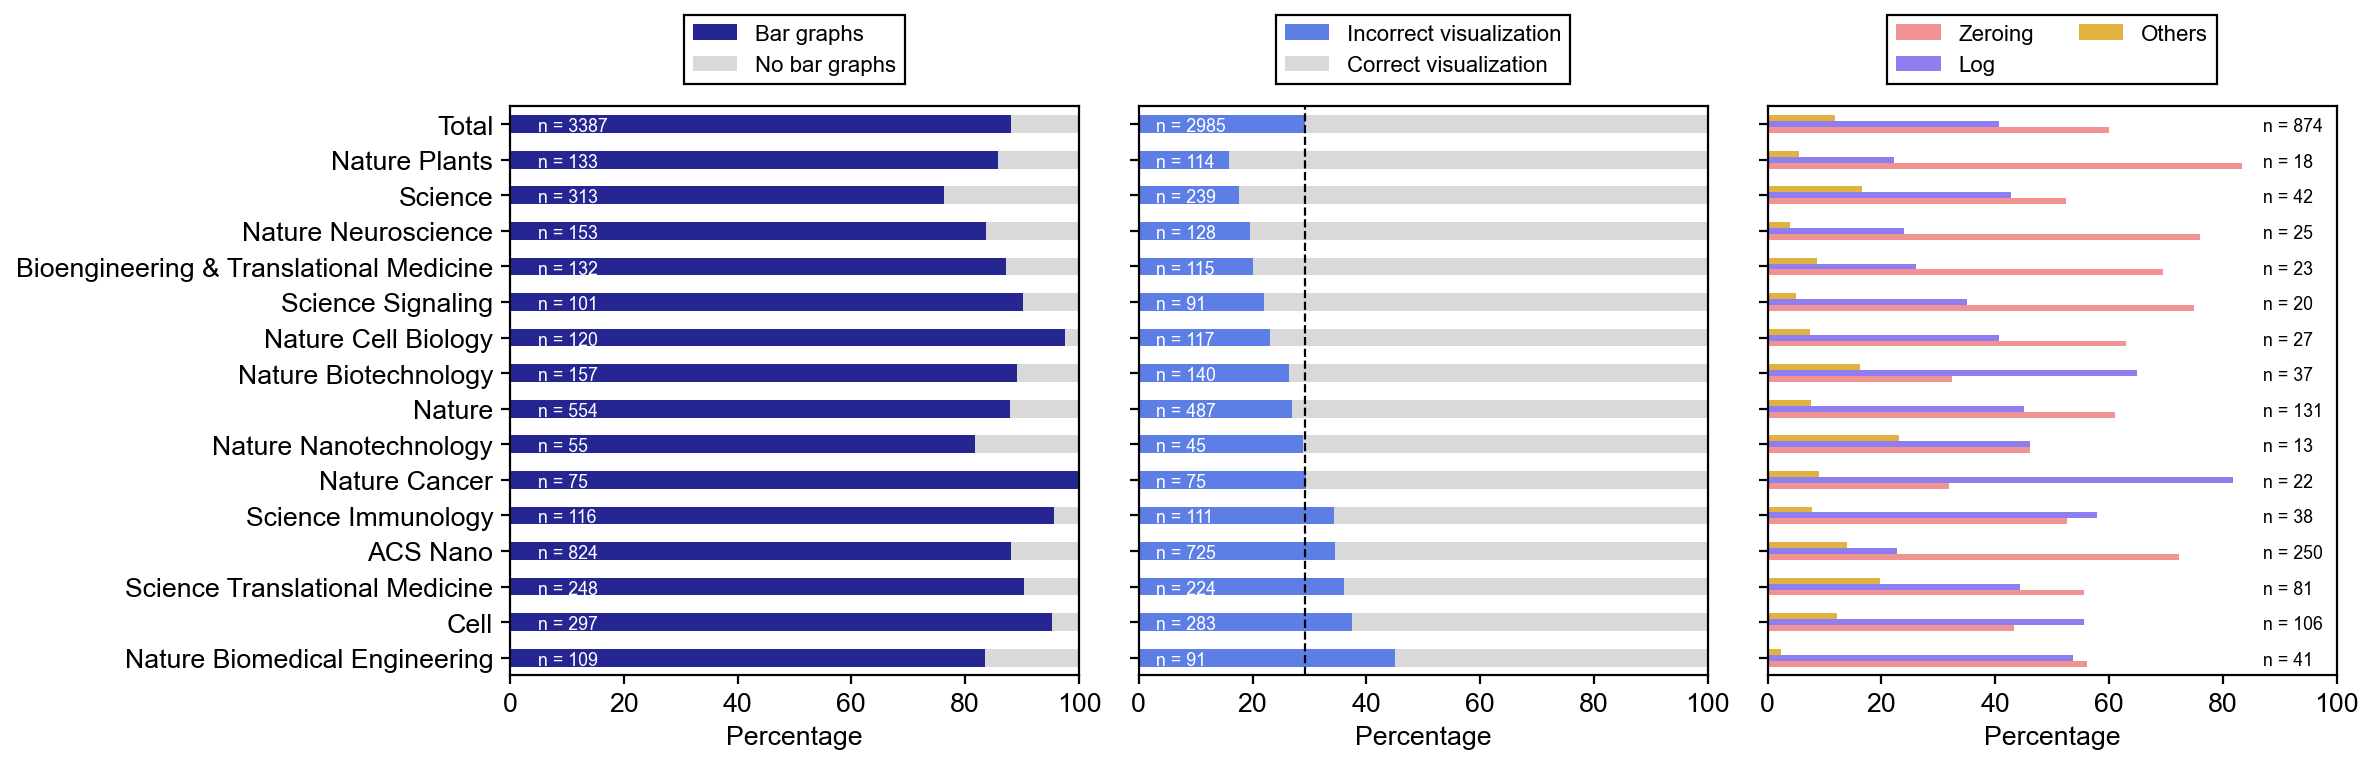

In [19]:
alpha = 0.85
total_misuse_percentage = percent_bar_correct_df.loc[TOTAL_LABEL, PERCENT_ARTICLES_INCORRECT_BAR_GRAPH_LABEL]
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
percent_bar_df.plot(
    kind='barh', 
    stacked=True, 
    ax=axs[0],
    legend=False,
    alpha=alpha,
    color=[ARTICLES_WITH_BAR_GRAPH_COLOR, ARTICLES_WITHOUT_BAR_GRAPH_COLOR], 
)
percent_bar_correct_df.plot(
    kind='barh', 
    stacked=True, 
    ax=axs[1],
    legend=False,
    alpha=alpha,
    color=[ARTICLES_INCORRECT_BAR_GRAPH_COLOR, ARTICLES_CORRECT_BAR_GRAPH_COLOR], 
)
percent_bar_incorrect_df.plot(
    kind='barh', 
    stacked=False, 
    ax=axs[2],
    legend=True,
    alpha=alpha,
    color=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR, ARTICLES_OTHER_PROBLEM_COLOR], 
)

# iterable plot settings
for i in range(2):
    axs[i].set_xlim(0, 100)
for i in range(3):
    axs[i].set_box_aspect(1)
    axs[i].set_xlabel('Percentage')

# individual plot settings
axs[0].set_ylabel('')
axs[2].set_xlim(0, 100)

# plot legends
axs[0].legend(
    ['Bar graphs', 'No bar graphs'], 
    bbox_to_anchor=(0.5, 1.02), 
    loc='lower center',
)
axs[1].legend(
    ['Incorrect visualization', 'Correct visualization'], 
    bbox_to_anchor=(0.5, 1.02), 
    loc='lower center',
)
axs[2].legend(
    [ZERO_LABEL, LOG_LABEL, OTHERS_LABEL], 
    bbox_to_anchor=(0.5, 1.02), 
    loc='lower center',
    ncol=2,
)

# overlay n onto bars in subplot 1/3
for i in range(total_articles_series.shape[0]):
    try:
        axs[0].text(5, i - 0.2, f'n = {int(total_articles_series.iloc[i])}', fontsize=8, color='w')
    except ValueError:
        pass

# overlay n onto bars in subplot 2/3
for i in range(total_articles_series.shape[0]):
    try:
        axs[1].text(3, i - 0.2, f'n = {int(articles_bar_graph_series.iloc[i])}', fontsize=8, color='w')
    except ValueError:
        pass

# overlay n onto bars in subplot 3/3
for i in range(total_articles_series.shape[0]):
    try:
        axs[2].text(87, i - 0.2, f'n = {int(articles_misused_bar_graph_series.iloc[i])}', fontsize=8, color='k')
    except ValueError:
        pass

# add average line to subplot 2/3
axs[1].axvline(
    total_misuse_percentage,
    color='k',
    lw=1,
    ls='--'
)
plt.tight_layout()
fig.savefig('figures/subpanels/fig-1abc-article-stat.pdf')

## Correlation of article classification statistics

### Construct structured files for quantity annotation

Change `generate_annotation` to True to generate (or override) a fresh quantity annotation sheet.

In [20]:
generate_annotation = False
file_df = pd.DataFrame()
for j, mistake in enumerate(MISTAKES):
    for i, journal in enumerate(JOURNALS):
        filepath = f'data/misused_bar_graph_figures/{journal}/{mistake}'
        file_list = pd.Series(sorted(os.listdir(filepath)))
        file_list = file_list[file_list.str.contains('.png')]
        file_list = file_list.str.replace('.png', '')
        figidx = file_list.copy()
        file_list = file_list.str.replace('fig', '')
        new_file_df = file_list.str.split('_', expand=True)
        new_file_df.columns = ['DOI', 'Mistake', 'Fig ID']
        new_file_df['Journal'] = journal
        new_file_df['Fig Index'] = figidx
        new_file_df = new_file_df.set_index('Fig Index')
        if generate_annotation:
            new_file_df.to_excel(os.path.join(filepath, 'annotation.xlsx'))

### Import quantity annotation data

In [21]:
bar_annot_df = pd.DataFrame()
for j, mistake in enumerate(MISTAKES):
    for i, journal in enumerate(JOURNALS):
        filepath = f'data/misused_bar_graph_figures/{journal}/{mistake}'
        filename = os.path.join(filepath, 'annotation.xlsx')
        bar_annot_df_ = pd.read_excel(filename)
        bar_annot_df = pd.concat([bar_annot_df, bar_annot_df_]).reset_index(drop=True)
bar_annot_df.shape

(3577, 11)

In [22]:
bar_annot_df.groupby(['DOI', 'Mistake', 'Measurand Level II']).count().iloc[:, 0]

DOI                           Mistake  Measurand Level II
10.1002:btm2.10487            log      Constant              2
10.1002:btm2.10499            zero     Concentration         6
10.1002:btm2.10504            zero     Concentration         1
10.1002:btm2.10505            zero     Concentration         2
10.1002:btm2.10514            log      Concentration         2
                                                            ..
10.1126:scitranslmed.adh4529  log      Percentage            2
10.1126:scitranslmed.adh7668  zero     Count                 1
10.1126:scitranslmed.adi1617  log      Fluorescence          1
10.1126:scitranslmed.adi7244  zero     Percentage            3
10.1126:scitranslmed.adi9867  log      Count                 2
Name: Fig Index, Length: 1196, dtype: int64

### Quantifying graph-level bias

In [23]:
# 同一种错误（mistake, Measurand Level I）在一个文章（DOI）里能犯错几次？
# journal redundant but for for later use
# how much graph-level bias can we get?
graph_bias_count_df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).count().iloc[:, 0]
graph_bias_count_df.name = 'Count'
graph_bias_count_df = graph_bias_count_df.reset_index()
graph_bias_count_df

,Journal,DOI,Mistake,Measurand Level I,Count
0,acs_nano,10.1021:acsnano.2c07293,zero,Temperature,1
1,acs_nano,10.1021:acsnano.2c07436,log,Others,1
2,acs_nano,10.1021:acsnano.2c07436,zero,Percentage,1
3,acs_nano,10.1021:acsnano.2c07439,zero,Relative luminescence,1
4,acs_nano,10.1021:acsnano.2c08153,log,Concentration,2
...,...,...,...,...,...
1236,science,10.1126:science.adi8885,log,Ratio,3
1237,science,10.1126:science.adi8885,zero,Cell count,15
1238,science,10.1126:science.adi8885,zero,Cell percentage,1
1239,science,10.1126:science.adi8885,zero,Percentage,1


(0.0, 25.0)

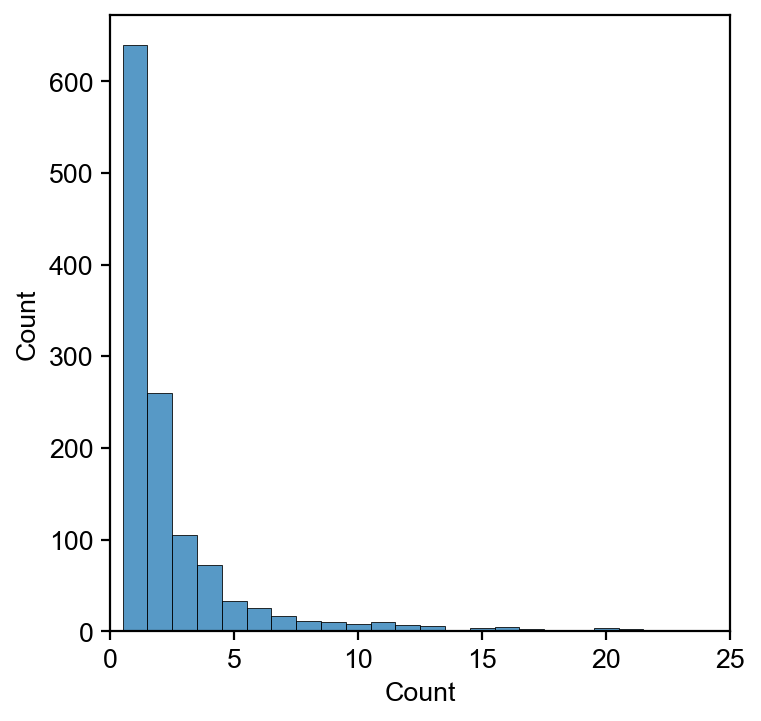

In [24]:
bins = np.arange(0.5, graph_bias_count_df['Count'].max() + 0.5, 1)
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(
    graph_bias_count_df,
    x='Count',
    bins=bins,
    ax=ax,
)
ax.set_xlim(0, 25)

(0.0, 25.0)

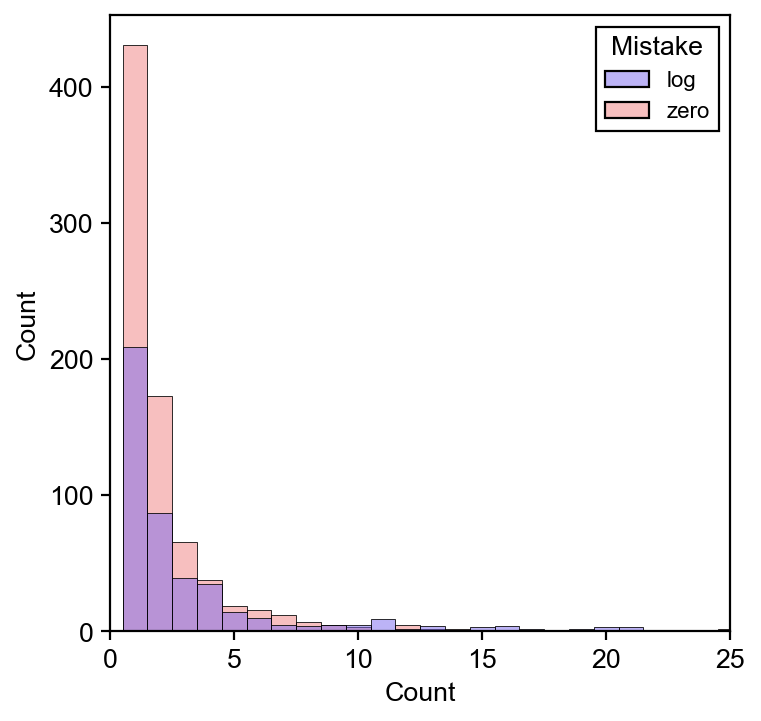

In [25]:
bins = np.arange(0.5, graph_bias_count_df['Count'].max() + 0.5, 1)
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(
    graph_bias_count_df,
    x='Count',
    hue='Mistake',
    bins=bins,
    hue_order=['log', 'zero'],
    palette=[ARTICLES_LOG_PROBLEM_COLOR, ARTICLES_ZERO_PROBLEM_COLOR],
    ax=ax,
)
ax.set_xlim(0, 25)

(0.0, 60.0)

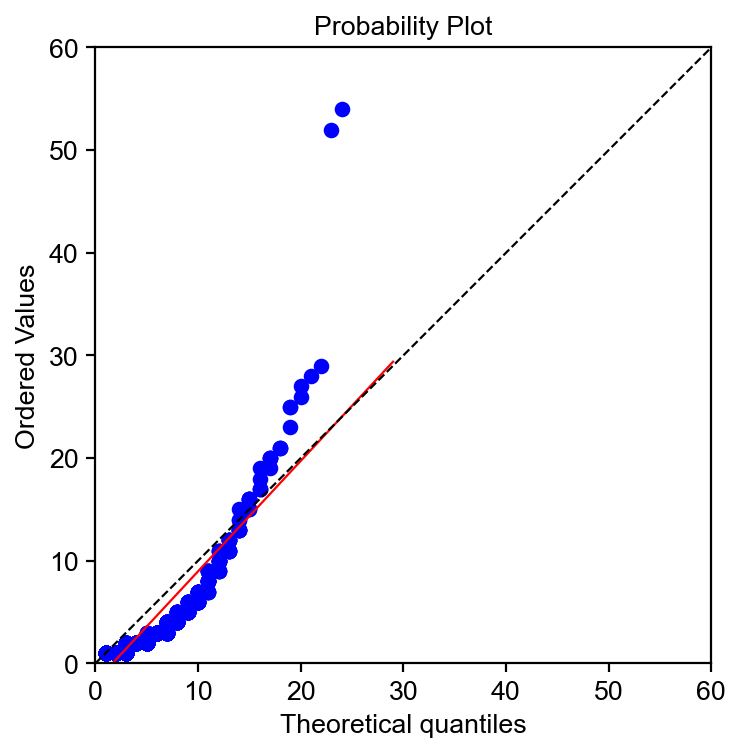

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
res = scipy.stats.probplot(
    graph_bias_count_df['Count'],
    dist=scipy.stats.geom,
    sparams=(0.23,),
    plot=ax,
)
ax.plot([0, 60], [0, 60], 'k--')
ax.set_box_aspect(1)
ax.set_aspect('equal')
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)

### Quantifying frequency of making mistakes

In [27]:
# 同一篇文章（DOI）里能犯几个不同的错误（mistake, physical quantity）？
# journal redundant but for later use
# how many mistake (with graph-level bias mitigated) do people make per article?

mistake_count_df = graph_bias_count_df.groupby(['Journal', 'DOI', 'Mistake']).count()['Count']
mistake_count_df = mistake_count_df.reset_index()
mistake_count_df

,Journal,DOI,Mistake,Count
0,acs_nano,10.1021:acsnano.2c07293,zero,1
1,acs_nano,10.1021:acsnano.2c07436,log,1
2,acs_nano,10.1021:acsnano.2c07436,zero,1
3,acs_nano,10.1021:acsnano.2c07439,zero,1
4,acs_nano,10.1021:acsnano.2c08153,log,1
...,...,...,...,...
872,science,10.1126:science.adi2246,log,2
873,science,10.1126:science.adi4720,zero,1
874,science,10.1126:science.adi8885,log,1
875,science,10.1126:science.adi8885,zero,3


(0.0, 7.0)

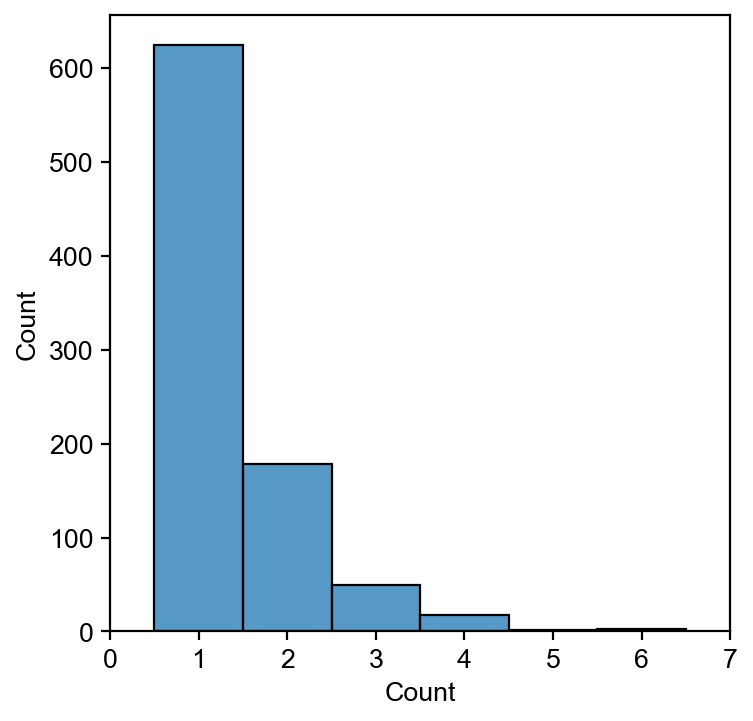

In [28]:
bins = np.arange(0.5, mistake_count_df['Count'].max() + 0.5, 1)
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(
    mistake_count_df,
    x='Count',
    bins=bins,
    ax=ax,
)
ax.set_xlim(0, 7)

(0.0, 7.0)

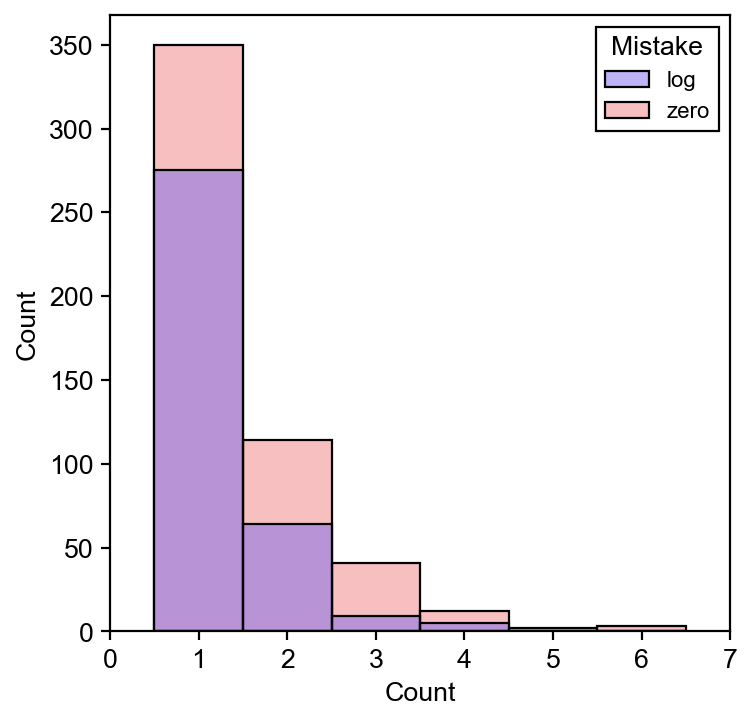

In [29]:
bins = np.arange(0.5, mistake_count_df['Count'].max() + 0.5, 1)
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(
    mistake_count_df,
    x='Count',
    hue='Mistake',
    bins=bins,
    hue_order=['log', 'zero'],
    palette=[ARTICLES_LOG_PROBLEM_COLOR, ARTICLES_ZERO_PROBLEM_COLOR],
    ax=ax,
)
ax.set_xlim(0, 7)

(0.0, 8.0)

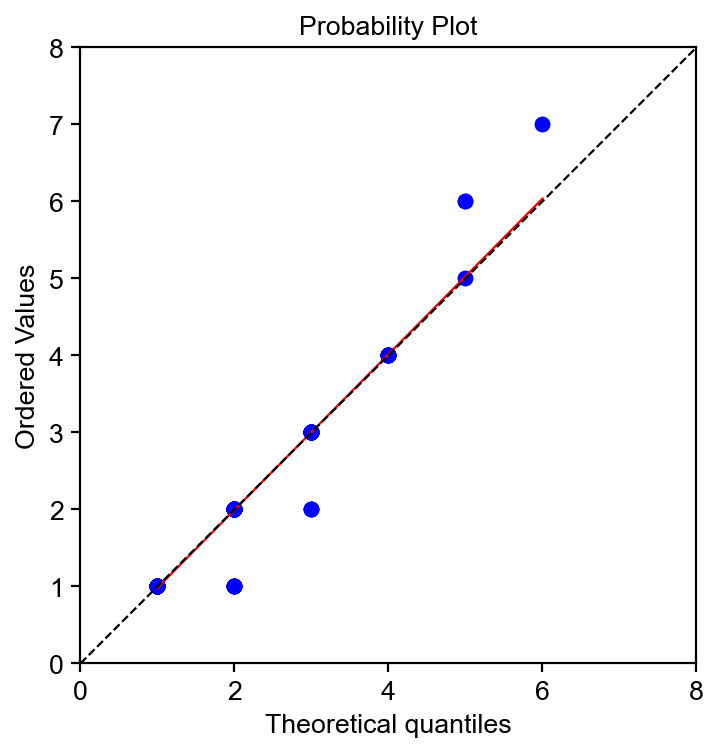

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
res = scipy.stats.probplot(
    mistake_count_df['Count'],
    dist=scipy.stats.geom,
    sparams=(0.7,),
    plot=ax,
)
xmax = 8
ymax = xmax
ax.plot([0, xmax], [0, ymax], 'k--')
ax.set_box_aspect(1)
ax.set_aspect('equal')
ax.set_xlim(0, xmax)
ax.set_ylim(0, ymax)

### Compiled graph

y = 1.06x + 1.65
R2 = 0.999
P value = 2.99e-20


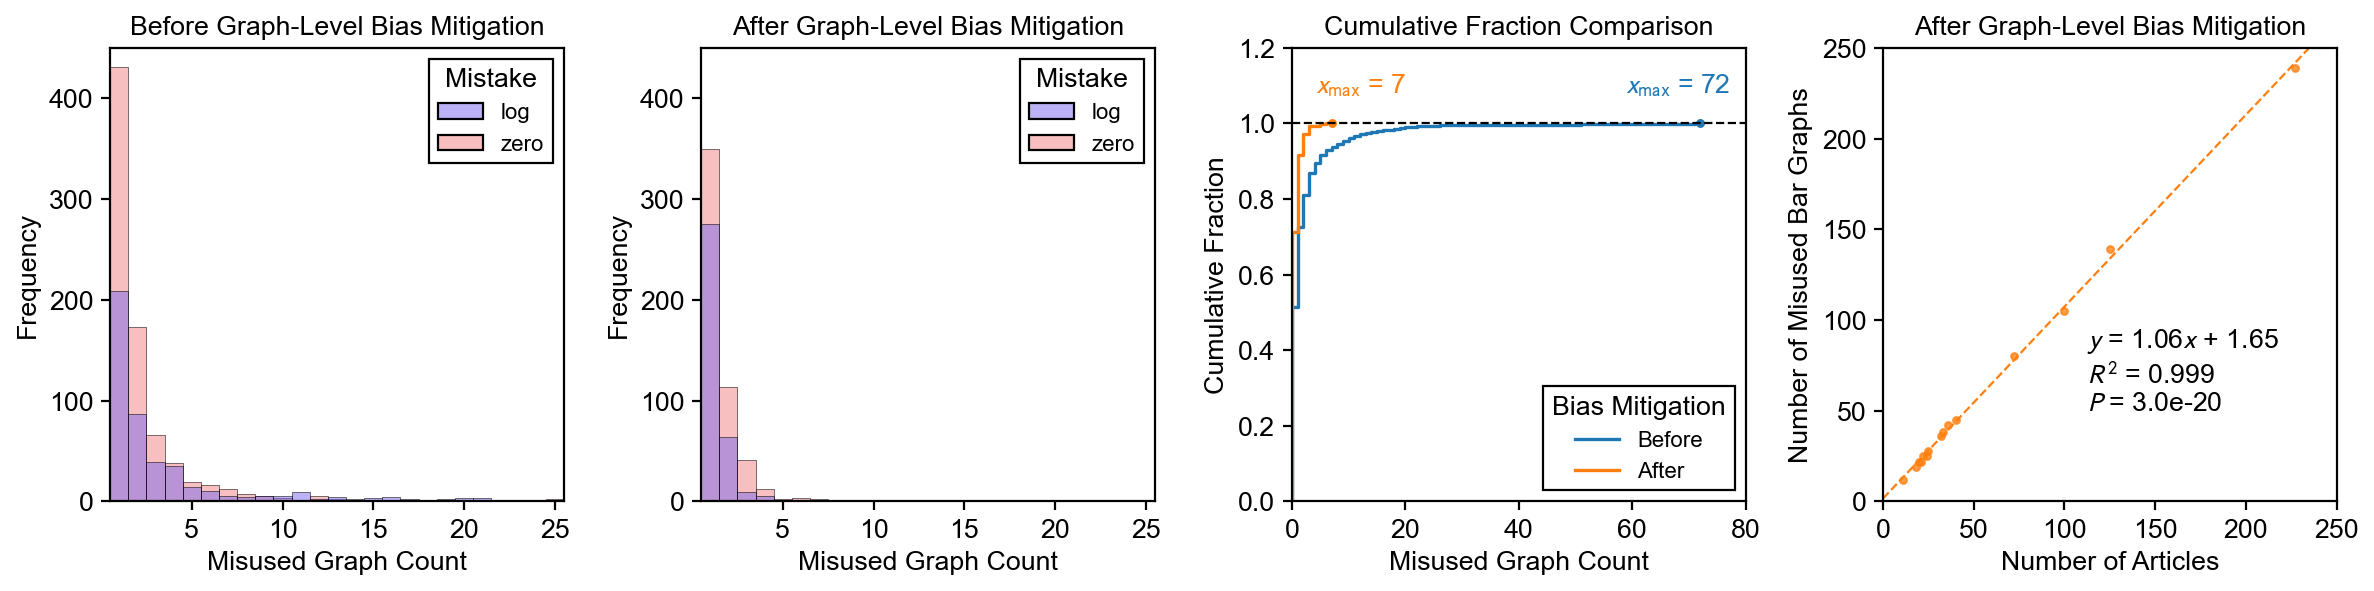

In [31]:
bins = np.arange(0.5, graph_bias_count_df['Count'].max() + 0.5, 1)
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
sns.histplot(
    graph_bias_count_df,
    x='Count',
    hue='Mistake',
    bins=bins,
    hue_order=['log', 'zero'],
    palette=[ARTICLES_LOG_PROBLEM_COLOR, ARTICLES_ZERO_PROBLEM_COLOR],
    ax=axs[0],
)
axs[0].set_xlim(0.5, 25.5)
axs[0].set_ylim(0, 450)
axs[0].set_title('Before Graph-Level Bias Mitigation')
axs[0].set_xlabel('Misused Graph Count')
axs[0].set_ylabel('Frequency')

# bins = np.arange(0.5, mistake_count_df['Count'].max() + 0.5, 1)
sns.histplot(
    mistake_count_df,
    x='Count',
    hue='Mistake',
    bins=bins,
    hue_order=['log', 'zero'],
    palette=[ARTICLES_LOG_PROBLEM_COLOR, ARTICLES_ZERO_PROBLEM_COLOR],
    ax=axs[1],
)
axs[1].set_xlim(0.5, 25.5)
axs[1].set_ylim(0, 450)
axs[1].set_title('After Graph-Level Bias Mitigation')
axs[1].set_xlabel('Misused Graph Count')
axs[1].set_ylabel('Frequency')

# subplot 3
mistake_count_df_time = [sum(mistake_count_df['Count'] <= i) / len(mistake_count_df['Count']) for i in range(mistake_count_df['Count'].max()+1)]
graph_bias_count_df_time = [sum(graph_bias_count_df['Count'] <= i) / len(graph_bias_count_df['Count']) for i in range(graph_bias_count_df['Count'].max()+1)]

axs[2].step(range(graph_bias_count_df['Count'].max()+1), graph_bias_count_df_time, lw=1.5, color='tab:blue', label='Before')
axs[2].plot(graph_bias_count_df['Count'].max(), 1, '.', color='tab:blue')
axs[2].step(range(mistake_count_df['Count'].max()+1), mistake_count_df_time, lw=1.5, color='tab:orange', label='After')
axs[2].plot(mistake_count_df['Count'].max(), 1, '.', color='tab:orange')
axs[2].set_xlabel('Misused Graph Count')
axs[2].set_ylabel('Cumulative Fraction')
axs[2].set_title('Cumulative Fraction Comparison')
axs[2].set_xlim(0, 80)
axs[2].set_ylim(0, 1.2)
axs[2].axhline(1, color='k', lw=1, ls='--')
axs[2].legend(title='Bias Mitigation', loc='lower right')
axs[2].text(
    0.85, 
    0.9,
    "$x_{\\max}$" + f" = {graph_bias_count_df['Count'].max()}",
    ha='center',
    transform=axs[2].transAxes,
    color='tab:blue',
)
axs[2].text(
    0.15, 
    0.9,
    "$x_{\\max}$" + f" = {mistake_count_df['Count'].max()}",
    ha='center',
    transform=axs[2].transAxes,
    color='tab:orange',
)

# number of articles with zeroing and log mistakes for each journal
x = bar_annot_df.groupby(['Journal', 'DOI']).count().iloc[:, 0].reset_index().groupby(['Journal']).count().iloc[:, 0].values
# effective number of bar graphs with zeroing and log mistakes after graph-level bias adjustment for each journal
y = mistake_count_df.groupby('Journal').count().iloc[:, 0].values
# linear fit
slope, intercept, rvalue, pvalue, _ = scipy.stats.linregress(x, y)
rsquared = rvalue ** 2
# linear fit points
x_fit = np.arange(0, 250)
y_fit = slope * x_fit + intercept
print(f'y = {slope:.3}x + {intercept:.3}')
print(f'R2 = {rsquared:.3}')
print(f'P value = {pvalue:.3}')

axs[3].plot(x, y, '.', color='tab:orange', alpha=0.75)
axs[3].plot(x_fit, y_fit, color='tab:orange', ls='--')
# axs[3].plot([0, 250], [0, 250], color='gray', ls='--')
axs[3].set_xlabel('Number of Articles')
axs[3].set_ylabel('Number of Misused Bar Graphs')
axs[3].set_title('After Graph-Level Bias Mitigation')
axs[3].set_xlim(0, 250)
axs[3].set_ylim(0, 250)
axs[3].set_box_aspect(1)
axs[3].text(
    0.45, 
    0.2,
    "$y$" + f" = {slope:.3}" + "$x$" + f" + {intercept:.3}" + "\n$R^2$" + f" = {rsquared:.3}" + '\n$P$ = ' + f'{pvalue:.1e}',
    ha='left',
    transform=axs[3].transAxes,
)

for i in range(4):
    axs[i].set_box_aspect(1)
plt.tight_layout()
fig.savefig('figures/subpanels/ex-fig-9-bias-mitigation.pdf')

In [32]:
print(f"First panel excluded {sum(graph_bias_count_df['Count'] > 25)}/{len(graph_bias_count_df['Count'])} = {sum(graph_bias_count_df['Count'] > 25) / len(graph_bias_count_df['Count'])}")

First panel excluded 8/1241 = 0.0064464141821112


## Amount of mistakes per journal

### Median

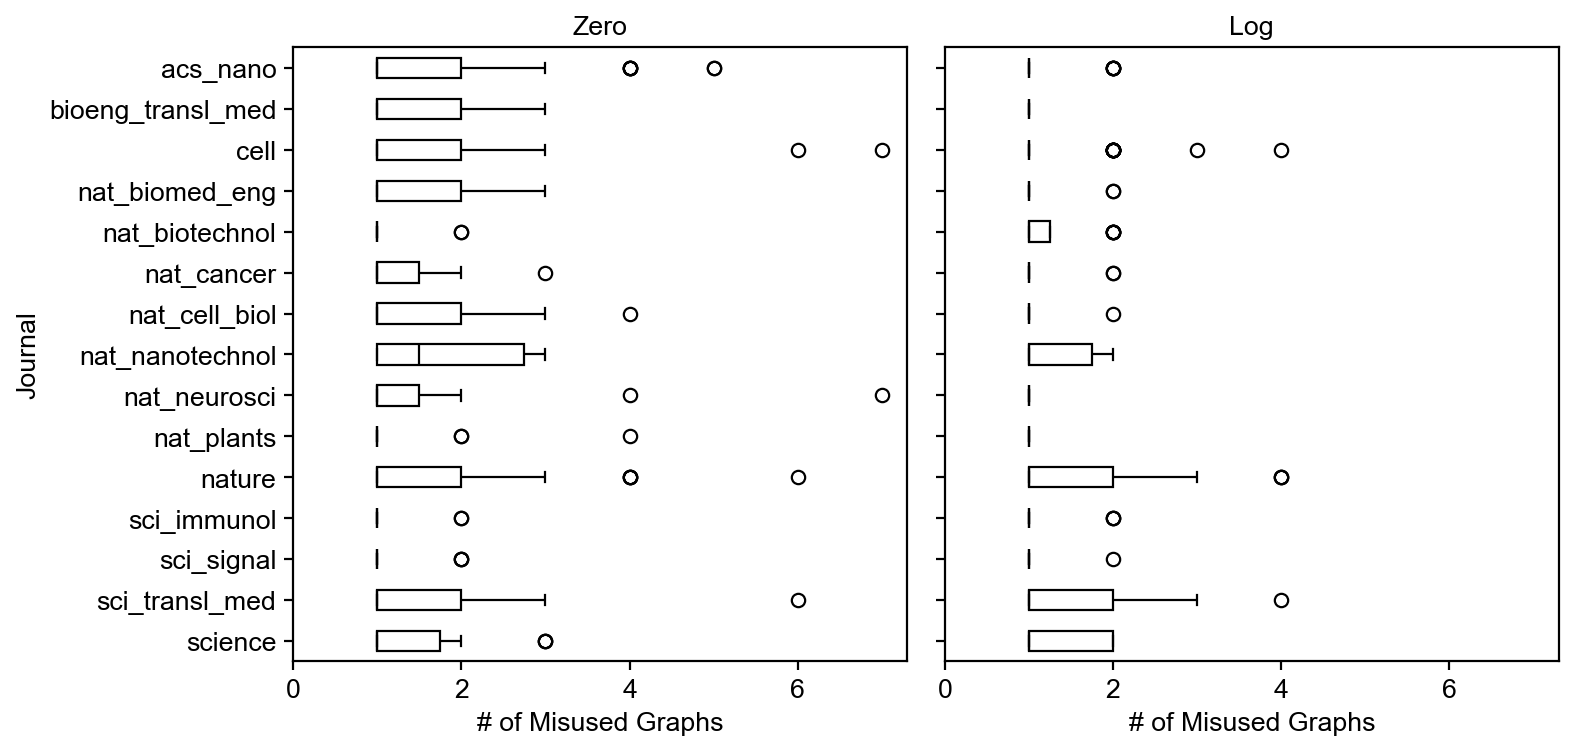

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
sns.boxplot(
    mistake_count_df[mistake_count_df['Mistake'] == 'zero'],
    y='Journal',
    x='Count',
    ax=axs[0],
    color='w',
    linecolor='k',
    width=0.5,
)
sns.boxplot(
    mistake_count_df[mistake_count_df['Mistake'] == 'log'],
    y='Journal',
    x='Count',
    ax=axs[1],
    color='w',
    linecolor='k',
    width=0.5,
)
axs[0].set_title('Zero')
axs[1].set_title('Log')
for i in range(2):
    axs[i].set_box_aspect(1)
    axs[i].set_xlim(0)
    axs[i].set_xlabel('# of Misused Graphs')
plt.tight_layout()

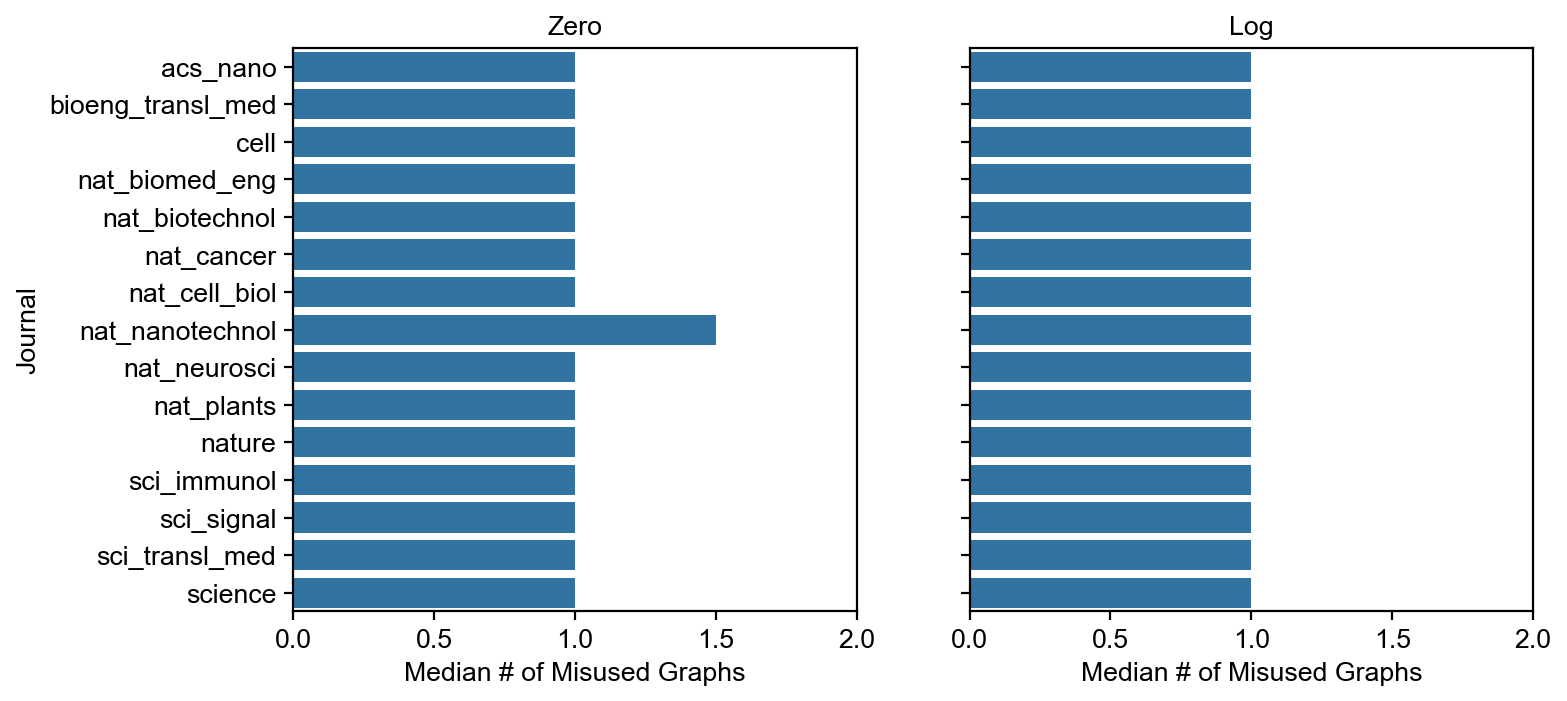

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
sns.barplot(
    mistake_count_df.loc[mistake_count_df['Mistake'] == 'zero'].groupby('Journal').agg({'Count': 'median'}).reset_index(),
    y='Journal',
    x='Count',
    ax=axs[0],
)
sns.barplot(
    mistake_count_df.loc[mistake_count_df['Mistake'] == 'log'].groupby('Journal').agg({'Count': 'median'}).reset_index(),
    y='Journal',
    x='Count',
    ax=axs[1],
)
axs[0].set_title('Zero')
axs[1].set_title('Log')
for i in range(2):
    axs[i].set_box_aspect(1)
    axs[i].set_xlim(0, 2)
    axs[i].set_xlabel('Median # of Misused Graphs')

### Mean

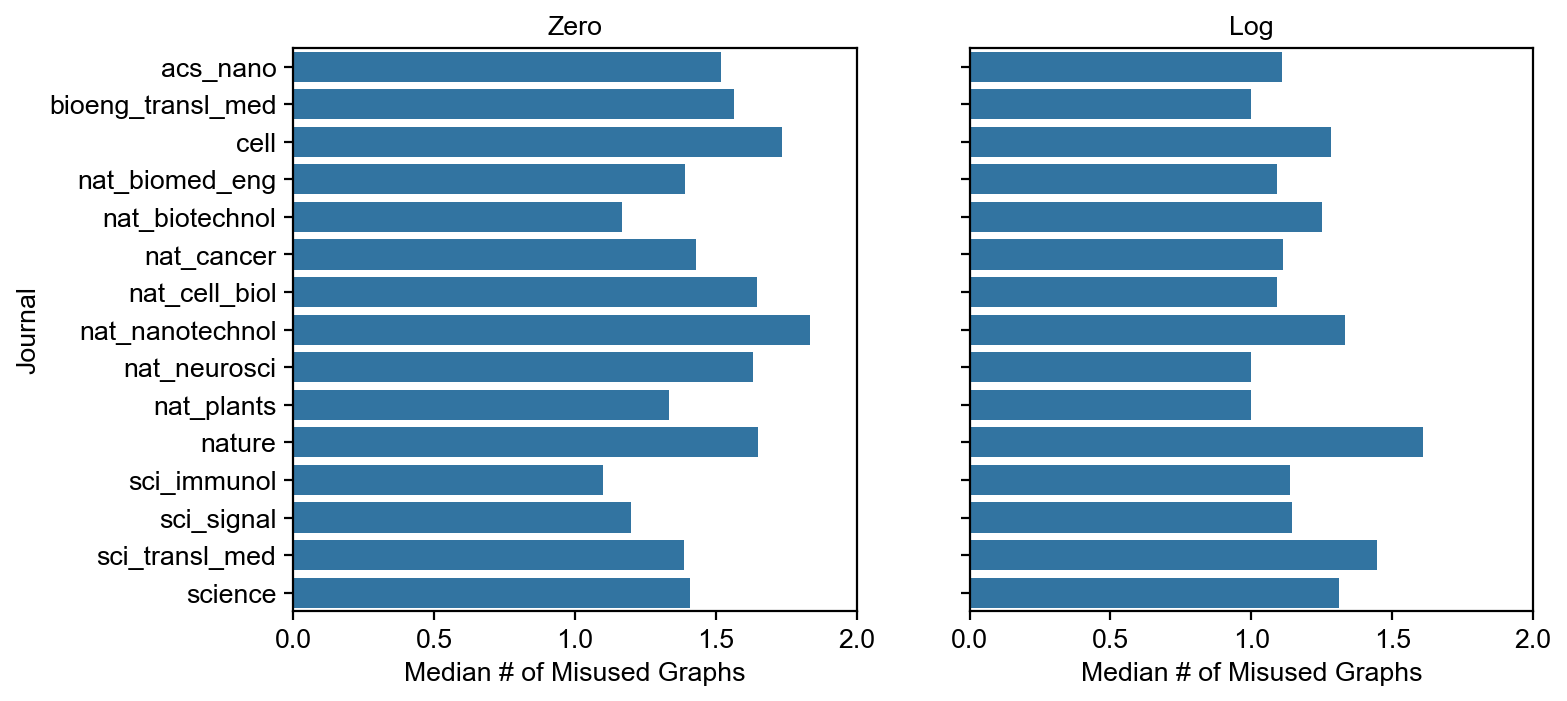

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
sns.barplot(
    mistake_count_df.loc[mistake_count_df['Mistake'] == 'zero'].groupby('Journal').agg({'Count': 'mean'}).reset_index(),
    y='Journal',
    x='Count',
    ax=axs[0],
)
sns.barplot(
    mistake_count_df.loc[mistake_count_df['Mistake'] == 'log'].groupby('Journal').agg({'Count': 'mean'}).reset_index(),
    y='Journal',
    x='Count',
    ax=axs[1],
)
axs[0].set_title('Zero')
axs[1].set_title('Log')
for i in range(2):
    axs[i].set_box_aspect(1)
    axs[i].set_xlim(0, 2)
    axs[i].set_xlabel('Median # of Misused Graphs')

## Correlation with number of authors

### Articles with bar graphs on average has more authors

In [36]:
def cohen_d(x, y):
    y_bar = np.mean(y)
    x_bar = np.mean(x)
    n_x = len(x)
    n_y = len(y)
    s_x = np.std(x)
    s_y = np.std(y)
    s = np.sqrt(
        ((n_x - 1) * s_x ** 2 + (n_y - 1) * s_y ** 2) / (n_x + n_y - 2)
    )
    d = (y_bar - x_bar) / s
    return d

def mad(x, c=1.4826):
    return c * np.median(np.abs(x - np.median(x)))
    
def pmad(x, y):
    n_x = len(x)
    n_y = len(y)
    mad_x = mad(x)
    mad_y = mad(y)
    pmad = np.sqrt(
        ((n_x - 1) * mad_x ** 2 + (n_y - 1) * mad_y ** 2) / (n_x + n_y - 2)
    )
    return pmad

def get_gamma(x, y, p=50):
    return np.abs(np.percentile(y, p) - np.percentile(x, p)) / pmad(x, y)

In [37]:
def label_stats(ax, pvalue, gamma):
    if pvalue < 0.001:
        ax.text(
            0.5, 
            0.9,
            '$\it{P}$ = ' + f'{pvalue:.1e}' + '\n$\gamma$ = ' + f'{gamma:.2}',
            ha='center',
            transform=ax.transAxes,
        )
    else:
        ax.text(
        0.5, 
        0.9,
        '$\it{P}$ = ' + f'{pvalue:.2}' + '\n$\gamma$ = ' + f'{gamma:.2}',
        ha='center',
        transform=ax.transAxes,
    )
    ax.axhline(
        0.875 * ax.get_ylim()[1],
        0.35, 
        0.65,
        color='k',
        lw=1,
    )

n = 2985 Bar graph
n = 402 No bar graph
Visualization excluded outlier 49/3387 = 0.01446708001180986
n = 874 Incorrect visualization
n = 2111 Correct visualization
Visualization excluded outlier 44/2985 = 0.01474036850921273
n = 524 Zeroing
n = 284 Log
Visualization excluded outlier 12/808 = 0.01485148514851485


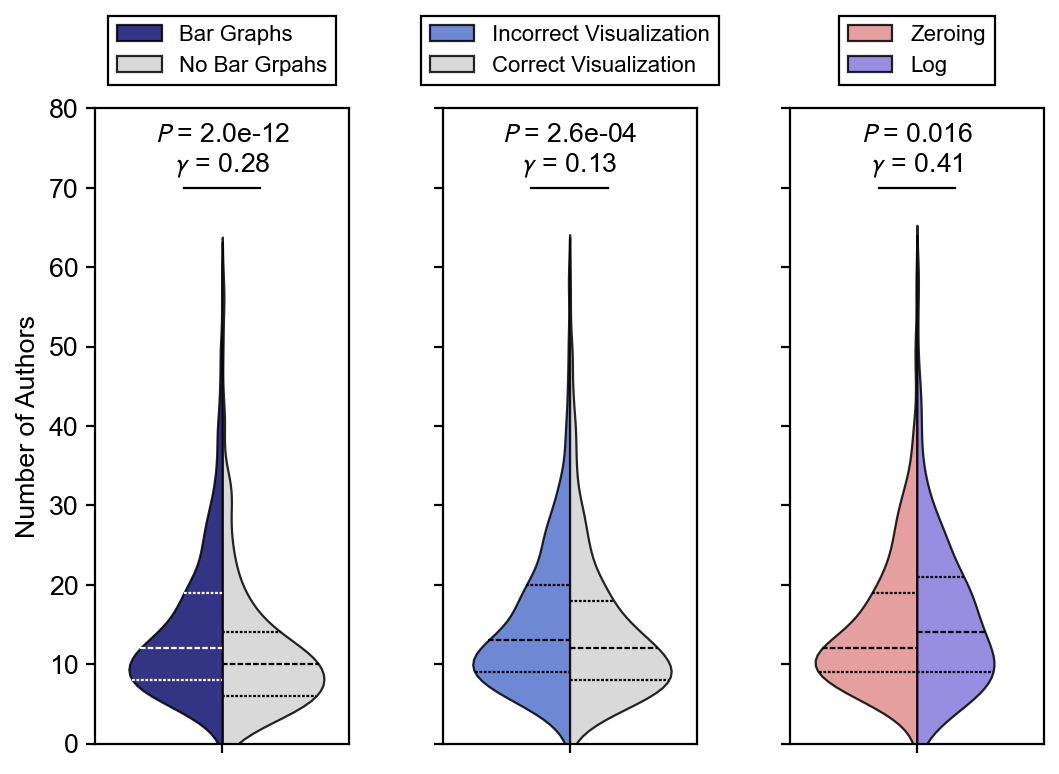

In [38]:
alpha = 0.85
author_count_viz_max = 60

fig, axs = plt.subplots(1, 3, figsize=(7, 5), sharey=True)
# common settings
for i in range(3):
    axs[i].set_ylim(0, 80)
    axs[i].set_box_aspect(2.5)

## subplot 1
print(f'n = {sum(articles_df[HAS_BAR_GRAPH_LABEL] == True)} Bar graph')
print(f'n = {sum(articles_df[HAS_BAR_GRAPH_LABEL] == False)} No bar graph')
print(f'Visualization excluded outlier {sum(articles_df[NUM_AUTHORS_LABEL] > author_count_viz_max)}/{len(articles_df)} = {sum(articles_df[NUM_AUTHORS_LABEL] > author_count_viz_max)/len(articles_df)}')
plot_df = articles_df[articles_df[NUM_AUTHORS_LABEL] <= author_count_viz_max]

violin = sns.violinplot(
    plot_df,
    y=NUM_AUTHORS_LABEL,
    hue=HAS_BAR_GRAPH_LABEL,
    split=True,
    inner="quart",
    density_norm='area',
    common_norm=True,
    hue_order=[True, False],
    palette=[ARTICLES_WITH_BAR_GRAPH_COLOR, ARTICLES_WITHOUT_BAR_GRAPH_COLOR],
    alpha=alpha,
    linecolor='black',
    linewidth=1,
    ax=axs[0],
)

# label statistics
stat, pvalue = scipy.stats.mannwhitneyu(
    articles_df.loc[articles_df[HAS_BAR_GRAPH_LABEL] == True, NUM_AUTHORS_LABEL],
    articles_df.loc[articles_df[HAS_BAR_GRAPH_LABEL] == False, NUM_AUTHORS_LABEL],
)
gamma = get_gamma(
    articles_df.loc[articles_df[HAS_BAR_GRAPH_LABEL] == True, NUM_AUTHORS_LABEL],
    articles_df.loc[articles_df[HAS_BAR_GRAPH_LABEL] == False, NUM_AUTHORS_LABEL],
)
label_stats(axs[0], pvalue, gamma)

# configure legend
sns.move_legend(
    violin, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=['Bar Graphs', 'No Bar Grpahs'],
    )
)

## subplot 2
plot_df = articles_df.loc[(articles_df[NO_MISUSE_LABEL] == True) | (articles_df[HAS_MISUSE_LABEL] == True)]
print(f'n = {sum(plot_df[HAS_MISUSE_LABEL] == True)} Incorrect visualization')
print(f'n = {sum(plot_df[HAS_MISUSE_LABEL] == False)} Correct visualization')
print(f'Visualization excluded outlier {sum(plot_df[NUM_AUTHORS_LABEL] > author_count_viz_max)}/{len(plot_df)} = {sum(plot_df[NUM_AUTHORS_LABEL] > author_count_viz_max)/len(plot_df)}')
plot_df = plot_df[plot_df[NUM_AUTHORS_LABEL] <= author_count_viz_max]

violin = sns.violinplot(
    plot_df,
    y=NUM_AUTHORS_LABEL,
    hue=HAS_MISUSE_LABEL,
    split=True,
    inner="quart",
    density_norm='area',
    common_norm=True,
    hue_order=[True, False],
    palette=[ARTICLES_INCORRECT_BAR_GRAPH_COLOR, ARTICLES_CORRECT_BAR_GRAPH_COLOR],
    alpha=alpha,
    linecolor='black',
    linewidth=1,
    ax=axs[1],
)

# label statistics
stat, pvalue = scipy.stats.mannwhitneyu(
    articles_df.loc[articles_df[NO_MISUSE_LABEL] == True, NUM_AUTHORS_LABEL],
    articles_df.loc[articles_df[HAS_MISUSE_LABEL] == True, NUM_AUTHORS_LABEL],
)
gamma = get_gamma(
    articles_df.loc[articles_df[NO_MISUSE_LABEL] == True, NUM_AUTHORS_LABEL],
    articles_df.loc[articles_df[HAS_MISUSE_LABEL] == True, NUM_AUTHORS_LABEL],
)
label_stats(axs[1], pvalue, gamma)

# configure legend
sns.move_legend(
    violin, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=['Incorrect Visualization', 'Correct Visualization'],
    )
)

## subplot 3
plot_df = articles_df.loc[(articles_df[ZERO_PROBLEM_LABEL] == True) | (articles_df[LOG_PROBLEM_LABEL] == True)]
print(f'n = {sum(plot_df[ZERO_PROBLEM_LABEL] == True)} Zeroing')
print(f'n = {sum(plot_df[ZERO_PROBLEM_LABEL] == False)} Log')
print(f'Visualization excluded outlier {sum(plot_df[NUM_AUTHORS_LABEL] > author_count_viz_max)}/{len(plot_df)} = {sum(plot_df[NUM_AUTHORS_LABEL] > author_count_viz_max)/len(plot_df)}')
plot_df = plot_df[plot_df[NUM_AUTHORS_LABEL] <= author_count_viz_max]

violin = sns.violinplot(
    plot_df,
    y=NUM_AUTHORS_LABEL,
    hue=ZERO_PROBLEM_LABEL,
    split=True,
    inner="quart",
    density_norm='area',
    common_norm=True,
    hue_order=[True, False],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    alpha=alpha,
    linecolor='black',
    linewidth=1,
    ax=axs[2],
)

# label statistics
stat, pvalue = scipy.stats.mannwhitneyu(
    articles_df.loc[articles_df[ZERO_PROBLEM_LABEL] == True, NUM_AUTHORS_LABEL],
    articles_df.loc[articles_df[LOG_PROBLEM_LABEL] == True, NUM_AUTHORS_LABEL],
)
gamma = get_gamma(
    articles_df.loc[articles_df[ZERO_PROBLEM_LABEL] == True, NUM_AUTHORS_LABEL],
    articles_df.loc[articles_df[LOG_PROBLEM_LABEL] == True, NUM_AUTHORS_LABEL],
)
label_stats(axs[2], pvalue, gamma)

# configure legend
sns.move_legend(
    violin, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
    )
)

# change quartile line color
for l in axs[0].lines[0:3]:
    l.set_color('white')

plt.tight_layout()
fig.savefig('figures/subpanels/ex-fig-6-author-number-correlation.pdf')

n = 2985 Bar graph
n = 402 No bar graph
n = 874 Incorrect visualization
n = 2111 Correct visualization
n = 524 Zeroing
n = 284 Log


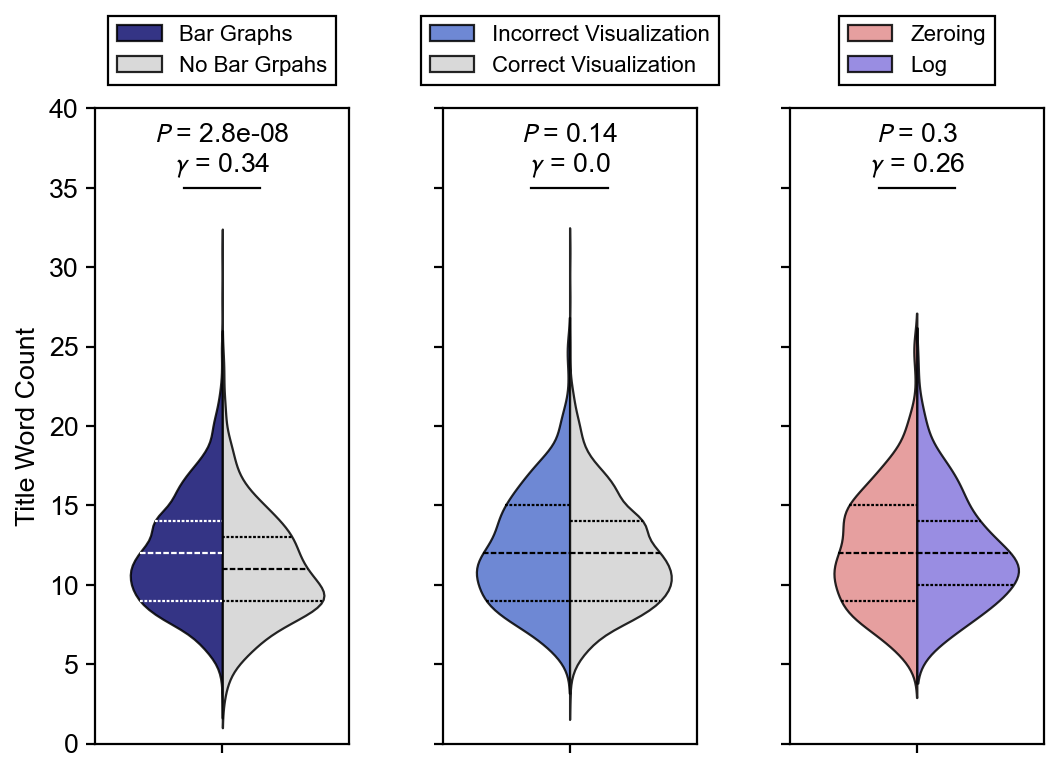

In [39]:
alpha = 0.85

fig, axs = plt.subplots(1, 3, figsize=(7, 5), sharey=True)
# common settings
for i in range(3):
    axs[i].set_ylim(0, 40)
    axs[i].set_box_aspect(2.5)
    
## subplot 1
print(f'n = {sum(articles_df[HAS_BAR_GRAPH_LABEL] == True)} Bar graph')
print(f'n = {sum(articles_df[HAS_BAR_GRAPH_LABEL] == False)} No bar graph')
plot_df = articles_df.copy()

violin = sns.violinplot(
    plot_df,
    y=NUM_WORDS_TITLE_LABEL,
    hue=HAS_BAR_GRAPH_LABEL,
    split=True,
    inner="quart",
    density_norm='area',
    common_norm=True,
    hue_order=[True, False],
    palette=[ARTICLES_WITH_BAR_GRAPH_COLOR, ARTICLES_WITHOUT_BAR_GRAPH_COLOR],
    alpha=alpha,
    linecolor='black',
    linewidth=1,
    ax=axs[0],
)

# label statistics
stat, pvalue = scipy.stats.mannwhitneyu(
    articles_df.loc[articles_df[HAS_BAR_GRAPH_LABEL] == True, NUM_WORDS_TITLE_LABEL],
    articles_df.loc[articles_df[HAS_BAR_GRAPH_LABEL] == False, NUM_WORDS_TITLE_LABEL],
)
gamma = get_gamma(
    articles_df.loc[articles_df[HAS_BAR_GRAPH_LABEL] == True, NUM_WORDS_TITLE_LABEL],
    articles_df.loc[articles_df[HAS_BAR_GRAPH_LABEL] == False, NUM_WORDS_TITLE_LABEL],
)
label_stats(axs[0], pvalue, gamma)

# configure legend
sns.move_legend(
    violin, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=['Bar Graphs', 'No Bar Grpahs'],
    )
)

## subplot 2
plot_df = articles_df.loc[(articles_df[NO_MISUSE_LABEL] == True) | (articles_df[HAS_MISUSE_LABEL] == True)]
print(f'n = {sum(plot_df[HAS_MISUSE_LABEL] == True)} Incorrect visualization')
print(f'n = {sum(plot_df[HAS_MISUSE_LABEL] == False)} Correct visualization')

violin = sns.violinplot(
    plot_df,
    y=NUM_WORDS_TITLE_LABEL,
    hue=HAS_MISUSE_LABEL,
    split=True,
    inner="quart",
    density_norm='area',
    common_norm=True,
    hue_order=[True, False],
    palette=[ARTICLES_INCORRECT_BAR_GRAPH_COLOR, ARTICLES_CORRECT_BAR_GRAPH_COLOR],
    alpha=alpha,
    linecolor='black',
    linewidth=1,
    ax=axs[1],
)

# label statistics
stat, pvalue = scipy.stats.mannwhitneyu(
    articles_df.loc[articles_df[NO_MISUSE_LABEL] == True, NUM_WORDS_TITLE_LABEL],
    articles_df.loc[articles_df[HAS_MISUSE_LABEL] == True, NUM_WORDS_TITLE_LABEL],
)
gamma = get_gamma(
    articles_df.loc[articles_df[NO_MISUSE_LABEL] == True, NUM_WORDS_TITLE_LABEL],
    articles_df.loc[articles_df[HAS_MISUSE_LABEL] == True, NUM_WORDS_TITLE_LABEL],
)
label_stats(axs[1], pvalue, gamma)

# configure legend
sns.move_legend(
    violin, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=['Incorrect Visualization', 'Correct Visualization'],
    )
)

## subplot 3
plot_df = articles_df.loc[(articles_df[ZERO_PROBLEM_LABEL] == True) | (articles_df[LOG_PROBLEM_LABEL] == True)]
print(f'n = {sum(plot_df[ZERO_PROBLEM_LABEL] == True)} Zeroing')
print(f'n = {sum(plot_df[ZERO_PROBLEM_LABEL] == False)} Log')

violin = sns.violinplot(
    plot_df,
    y=NUM_WORDS_TITLE_LABEL,
    hue=ZERO_PROBLEM_LABEL,
    split=True,
    inner="quart",
    density_norm='area',
    common_norm=True,
    hue_order=[True, False],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    alpha=alpha,
    linecolor='black',
    linewidth=1,
    ax=axs[2],
)

# label statistics
stat, pvalue = scipy.stats.mannwhitneyu(
    articles_df.loc[articles_df[ZERO_PROBLEM_LABEL] == True, NUM_WORDS_TITLE_LABEL],
    articles_df.loc[articles_df[LOG_PROBLEM_LABEL] == True, NUM_WORDS_TITLE_LABEL],
)
gamma = get_gamma(
    articles_df.loc[articles_df[ZERO_PROBLEM_LABEL] == True, NUM_WORDS_TITLE_LABEL],
    articles_df.loc[articles_df[LOG_PROBLEM_LABEL] == True, NUM_WORDS_TITLE_LABEL],
)
label_stats(axs[2], pvalue, gamma)

# configure legend
sns.move_legend(
    violin, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
    )
)

# change quartile line color
for l in axs[0].lines[0:3]:
    l.set_color('white')

plt.tight_layout()